In [1]:
import gpytorch
import matplotlib.pyplot as plt
import torch
from func_data_generation import *
from func_polygon import *

# from torchsummary import summary
from my_linear_kernel import MyLinearKernel
from torch import nn
from utils import *
from warp_units import *

dtype = torch.double
device = "cuda" if torch.cuda.is_available() else "cpu"
# device =  "cpu"
print("Using {} device".format(device))

import tqdm

torch.set_default_dtype(dtype)
%matplotlib inline
%load_ext autoreload
%autoreload 2

from datetime import datetime

from torch.utils.tensorboard import SummaryWriter

Using cuda device


In [2]:
class QuodralMean(gpytorch.means.Mean):
    def __init__(self):
        super().__init__()
        self.register_parameter(
            name="weights",
            parameter=torch.nn.Parameter(torch.randn(5, 1)),
        )
        self.register_parameter(
            name="bias", parameter=torch.nn.Parameter(torch.randn(1))
        )

    def forward(self, x):
        xx = torch.stack(
            (
                x[:, 0] * x[:, 0],
                x[:, 0] * x[:, 1],
                x[:, 1] * x[:, 1],
                x[:, 0],
                x[:, 1],
            ),
            dim=1,
        )
        res = xx.matmul(self.weights).squeeze(-1)
        return res + self.bias


class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ZeroMean()
        #         self.mean_module = QuodralMean()
        #         self.covar_module = gpytorch.kernels.LinearKernel(
        #             num_dimensions=2
        #         ) * gpytorch.kernels.LinearKernel(num_dimensions=2)
        self.covar_module = gpytorch.kernels.ScaleKernel(
            gpytorch.kernels.PolynomialKernel(power=2)
        )

        self.register_parameter(
            name="offset", parameter=torch.nn.Parameter(torch.zeros(1, 2))
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x - self.offset)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [3]:
data_num = 4
sensor_num = 200  # [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

# load data
data_filename = DATA_PATH + "/datasets_" + str(data_num) + ".hd5f"

if os.path.exists(data_filename):
    with h5py.File(data_filename, "r") as f1:
        coords = f1["coords"][...]
        true_rss = f1["true_rss"][...]
        observed_rss = f1["observed_rss"][...]
        train_X = f1["train_" + str(sensor_num) + "/train_X"][...]
        train_y = f1["train_" + str(sensor_num) + "/train_y"][...]
        idx = f1["train_" + str(sensor_num) + "/idx"][...]

In [4]:
# Normalize train_X to 0-1
train_X_tensor = torch.from_numpy(train_X).to(device) / 1000
coords_tensor = torch.from_numpy(coords).to(device) / 1000

train_y_tensor = torch.from_numpy(train_y).to(device)
train_y_mean = train_y_tensor.mean()
train_y_tensor = train_y_tensor - train_y_mean
# train_y_sigma = torch.sqrt(train_y_tensor.var())
# train_y_tensor = (train_y_tensor - train_y_mean) / train_y_sigma

In [5]:
# initialize likelihood and model

likelihood = gpytorch.likelihoods.GaussianLikelihood().to(device)
model = ExactGPModel(train_X_tensor, train_y_tensor, likelihood).to(device)
model.likelihood.noise = 0.2
# model.covar_module.base_kernel.lengthscale = 1
# model.covar_module.outputscale = 50

In [6]:
for name, param in model.named_parameters():
    print(f"Layer:{name} | Size:{param.size()} | Values : {param} \n")
#     print(f"Layer:{name} | Size:{param.size()} |  \n")

Layer:offset | Size:torch.Size([1, 2]) | Values : Parameter containing:
tensor([[0., 0.]], device='cuda:0', requires_grad=True) 

Layer:likelihood.noise_covar.raw_noise | Size:torch.Size([1]) | Values : Parameter containing:
tensor([-1.5083], device='cuda:0', requires_grad=True) 

Layer:covar_module.raw_outputscale | Size:torch.Size([]) | Values : 0.0 

Layer:covar_module.base_kernel.raw_offset | Size:torch.Size([1]) | Values : Parameter containing:
tensor([0.], device='cuda:0', requires_grad=True) 



In [7]:
model.train()
likelihood.train()
# Use the adam optimizer
optimizer = torch.optim.Adam(
    [
        {"params": model.offset},
        {"params": model.covar_module.parameters()},
        #         {"params": model.mean_module.parameters()},
        #         {"params": model.likelihood.parameters()},
    ],
    lr=0.01,
)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)


def train():
    iterator = tqdm.notebook.tqdm(range(training_iterations))
    for i, j in enumerate(iterator):
        # Zero backprop gradients
        optimizer.zero_grad()
        # Get output from model
        output = model(train_X_tensor)
        # Calc loss and backprop derivatives
        loss = -mll(output, train_y_tensor)
        loss.backward()
        #         iterator.set_postfix(
        #             loss=loss.item(),
        #             #             output_scale=model.covar_module.outputscale.item(),
        #             #             big_output_scale=model.covar_module.kernels[1].outputscale.item(),
        #             #             big_lengthscale=model.covar_module.kernels[
        #             #                 1
        #             #             ].base_kernel.lengthscale.item(),
        #             #             leng_scale=model.covar_module.kernels.base_kernel.lengthscale.item(),
        #             noise=model.likelihood.noise.item(),
        #         )
        if i % 10 == 9:
            writer.add_scalar("loss", loss.item(), i)
            writer.add_scalar("offset0", model.offset[0, 0].item(), i)
            writer.add_scalar("offset1", model.offset[0, 1].item(), i)
        #             writer.add_scalar("output_scale", model.covar_module.outputscale.item(), i)
        #             writer.add_scalar("noise", model.likelihood.noise.item(), i)

        optimizer.step()

In [8]:
now = datetime.now()
log_dir = "logs/gp/" + now.strftime("%Y%m%d-%H%M%S") + "/"
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(log_dir)

training_iterations = 10000
%time train()

  0%|          | 0/10000 [00:00<?, ?it/s]

CPU times: user 40min 28s, sys: 37.2 s, total: 41min 5s
Wall time: 1min 34s


In [94]:
model.offset[0, 0]

tensor(-0.5426, device='cuda:0', grad_fn=<SelectBackward>)

In [9]:
likelihood.eval()
model.eval()
observed_pred = model(coords_tensor)
mean = observed_pred.mean.detach() + train_y_mean
var = observed_pred.variance.detach()

In [11]:
save_result("result_4", "free_path", sensor_num, mean.cpu().numpy(), var.cpu().numpy())

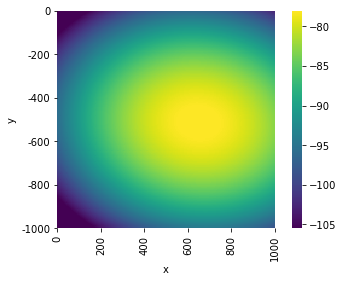

In [10]:
fig, ax = plt.subplots()
plot_heatmap(
    coords,
    mean,
    ax=ax,
    robust=True,
    cbar=True,
    #     vmin=-103,
    #     vmax=-63,
)

In [ ]:
mean

In [21]:
temp = 1.0 + torch.exp(torch.tensor(1.5)) / 2.0

In [22]:
temp

tensor(3.2408)

In [21]:
point = torch.tensor([[2.5, -2.5]]).to(device)
warp_model(point)

tensor([[ 2.6314, -1.8408]], device='cuda:0', grad_fn=<StackBackward>)

In [13]:
model.covar_module.kernels[1].base_kernel.lengthscale

tensor([[0.6931]], device='cuda:0', grad_fn=<SoftplusBackward>)